In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
import hbUtils
import subprocess
import os
import glob
import re
%matplotlib inline
%load_ext rpy2.ipython

Note: no visible global function definition for 'radixsort' 



In [52]:
datapath = '/data/mm10/Liver/RNA/'
outdir = '/home/h1bennet/scratch/171116_WholeLIver_RNASeq_Strains'
samples = ['aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3A_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam',
'aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3B_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam',
'aj_WholeLiver_RNA_polyA_AMLNDiet_30week_AJ3C_JSS_TDT_16_09_28.aj.star_shifted_from_AJ.sam',
'aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1A_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam',
'aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1B_JSS_TDT_16_09_26.aj.star_shifted_from_AJ.sam',
'aj_WholeLiver_RNA_polyA_ControlDiet_30week_AJ1C_JSS_TDT_16_09_28.aj.star_shifted_from_AJ.sam',
'balbc_WholeLiver_RNA_polyA_AMLNDiet_30week_BALB3A_JSS_TDT_16_09_28.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_AMLNDiet_30week_BALB3B_JSS_TDT_16_09_26.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_AMLNDiet_30week_BALB3C_TDT_JSS_16_09_26.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_AMLNDiet_30week_BALB3D_TDT_JSS_16_09_28.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_ControlDiet_30week_BALB1A_JSS_TDT_16_09_26.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_ControlDiet_30week_BALB1B_JSS_TDT_16_09_26.balbcj.star_shifted_from_BALBCJ.sam',
'balbc_WholeLiver_RNA_polyA_ControlDiet_30week_BALB1C_JSS_TDT_16_09_28.balbcj.star_shifted_from_BALBCJ.sam',
'NCoRWT_WholeLiver_RNA_polyA_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19',
'NCoRWT_WholeLiver_RNA-polyA-AMLNDiet-30week-LN141A-JSS-TDT-16-09-21',
'NCoRWT_WholeLiver_RNA-polyA-ControlDiet-30week-LN134B-JSS-TDT-16-09-21',
'NCoRWT_WholeLiver_RNA-polyA-ControlDiet-30week-LN134C-JSS-TDT-16-09-19',
'NCoRWT_WholeLiver_RNA_polyA_ControlDiet_30week_LN134D_JSS_TDT_16_09_21']

samplepaths = [datapath + '/' + s for s in samples]

samplesDF = pd.DataFrame(samples, columns = ['Samples'])
samplesDF['samplepaths'] = [datapath + '/' + s for s in samples]
samplesDF['batch'] = pd.factorize(pd.Series(samples)\
             .str.replace('-','_')\
             .str.findall(r'(\d+_\d+_\d+)').str[0])[0]
samplesDF['strain'] = [j.replace('-', '_').split('_')[0].lower() for j in samplesDF.Samples]
samplesDF['diet'] = ['AMLN' if 'AMLN' in name else 'Control' for name in samplesDF.Samples]
samplesDF['color'] = ['b'] * len(samplesDF)
samplesDF.color.loc[(samplesDF.strain == 'aj') & (samplesDF.diet == 'Control')] = '#fb9a99'
samplesDF.color.loc[(samplesDF.strain == 'aj') & (samplesDF.diet == 'AMLN')] = '#e31a1c'
samplesDF.color.loc[(samplesDF.strain == 'balbc') & (samplesDF.diet == 'Control')] = '#a6cee3'
samplesDF.color.loc[(samplesDF.strain == 'balbc') & (samplesDF.diet == 'AMLN')] = '#1f78b4'
samplesDF.color.loc[(samplesDF.strain == 'ncorwt') & (samplesDF.diet == 'Control')] = '#b2df8a'
samplesDF.color.loc[(samplesDF.strain == 'ncorwt') & (samplesDF.diet == 'AMLN')] = '#33a02c'
samplesDF['group'] = samplesDF.strain + '-' + samplesDF.diet

/home/h1bennet/anaconda3/envs/rnaseq/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
def run_annotateRepeats(dirpaths, genome = 'mm10', countType = 'genes',
                        raw = False, print_out = False, norm = None):
    '''Python wrapper for analyzeRepeates.pl
    Right now a basic implementation, evnetually add more
    functionality for variables to be passed'''
    import subprocess
    aRCall = ['analyzeRepeats.pl', 'rna', genome, '-count', countType]
    if raw:
        aRCall.extend(['-raw'])
    elif norm !=None:
        aRCall.extend(['-' + norm])
    else:
        aRCall.extend(['-norm', '1e7'])
    aRCall.extend(['-d'])
    aRCall.extend(dirpaths)
    if print_out: print(aRCall)
    p = subprocess.Popen(aRCall, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    out, err = p.communicate()
    
    return out, err

def run_getDiffExpression(dirpaths, groups, batch = None, genome = 'mm10', countType = 'genes', print_out = False):
    '''Python wrapper for getDiffExpression.pl
    groups should be the experimental groups for analysis
    batch can be used to control for experimental date
    see documentation for getDiffExprssion.pl for more info
    
    eventually implement option to control the algorithm used'''
    import subprocess
    
    # Run annotate repeats with no adjustments
    out, err = run_annotateRepeats(dirpaths, countType = countType, raw = True)
    f = open(outdir + '/tmpARForgDE.txt', 'w')
    f.write(out.decode('utf-8'))
    f.close()
    
    # Run diff exp
    gDECall = ['getDiffExpression.pl', outdir + '/tmpARForgDE.txt']
    gDECall.extend(groups)
    # gDECall.extend(['-edgeR'])
    if batch is not None:
        gDECall.extend(['-batch'])
        gDECall.extend(batch)
    if print_out: print(gDECall)
    p = subprocess.Popen(gDECall, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    gDEOut, gDEErr = p.communicate()
    
    subprocess.call(['rm', outdir + '/tmpARForgDE.txt'])
    return gDEOut, gDEErr

def df_col_subset(x, id_str):
    '''Returns pandas dataframe with only columns containing id_str'''
    return x[x.columns[pd.Series(x.columns).str.contains(id_str)]]

In [47]:
## CONSIDER IMPLEMENTATION OF -PC 3 or -PC 4?

# Run annotate repeats
out, err = run_annotateRepeats(samplepaths, countType = 'genes')
f = open(outdir + '/rnaseq_matrixGenes.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons with raw counts for DESeq
out, err = run_annotateRepeats(samplepaths, countType='genes', raw=True)
f = open(outdir + '/rnaseq_matrixGenesRaw.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons - rlog normalized for plotting
out, err = run_annotateRepeats(samplepaths, countType = 'genes', norm='rlog')
f = open(outdir + '/rnaseq_matrixGenes_rlog.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons - rpkm normalized for conversion to tpm
out, err = run_annotateRepeats(samplepaths, countType = 'genes', norm='rpkm')
f = open(outdir + '/rnaseq_matrixGenes_rpkm.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons
out, err = run_annotateRepeats(samplepaths, countType = 'exons')
f = open(outdir + '/rnaseq_matrixExons.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons with raw counts for DESeq
out, err = run_annotateRepeats(samplepaths, countType='exons', raw=True)
f = open(outdir + '/rnaseq_matrixExonsRaw.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons - rlog normalized for plotting
out, err = run_annotateRepeats(samplepaths, countType = 'exons', norm='rlog')
f = open(outdir + '/rnaseq_matrixExons_rlog.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons - rpkm normalized for conversion to tpm
out, err = run_annotateRepeats(samplepaths, countType = 'exons', norm='rpkm')
f = open(outdir + '/rnaseq_matrixExons_rpkm.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

In [49]:
# Run annotate repeats for exons with raw counts for DESeq
out, err = run_annotateRepeats(samplepaths, countType='genes', raw=True)
f = open(outdir + '/rnaseq_matrixGenesRaw.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons - rlog normalized for plotting
out, err = run_annotateRepeats(samplepaths, countType = 'genes', norm='rlog')
f = open(outdir + '/rnaseq_matrixGenes_rlog.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons - rpkm normalized for conversion to tpm
out, err = run_annotateRepeats(samplepaths, countType = 'genes', norm='rpkm')
f = open(outdir + '/rnaseq_matrixGenes_rpkm.txt', 'w')
f.write(out.decode('utf-8'))
f.close()


### PCA Analysis of the Data

In [50]:
# import rpkm counts as output by annotateRepeats
rpkm = pd.read_csv(outdir + '/rnaseq_matrixExons_rpkm.txt', sep='\t')

# Create column for gene
rpkm['Gene'] = pd.Series([x.split('|')[0] for x in rpkm['Annotation/Divergence']])

# clean up the columns a bit
pattern = r"\s+\(.+\)$"
rpkm.columns = pd.Series(rpkm.columns)\
        .str.replace(pattern, '')\
        .str.split('/')\
        .str[-1]
        
#subset matrix of only counts
rpkm_mat = rpkm.set_index('RepeatID')[rpkm.columns[
        rpkm.columns.to_series().str.contains('RNA')]]

# create tpm matrix
tpm_mat = rpkm_mat.apply(lambda x: x * (10**6)/x.sum())

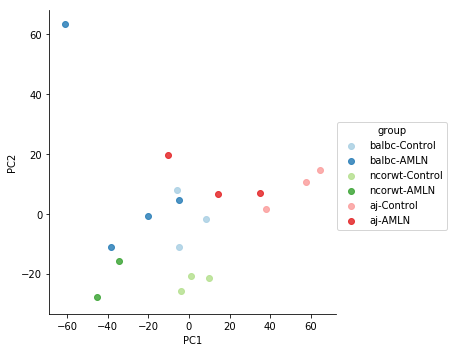

In [55]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# want to run the algorithms on standard scaled data
# mean = 0, variance = 1
tpm_std = StandardScaler().fit_transform(tpm_mat) # scale data
pca = PCA(n_components=2)
tpm_pca = pca.fit_transform(tpm_std.T)

# Plot Results
pca_order = ['balbc-Control', 'balbc-AMLN', 'ncorwt-Control',
             'ncorwt-AMLN', 'aj-Control', 'aj-AMLN']

tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2'],
        index=samplesDF.group).reset_index()
with sns.color_palette('Paired'):
    sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
               hue='group', hue_order = pca_order)

/home/h1bennet/anaconda3/envs/rnaseq/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


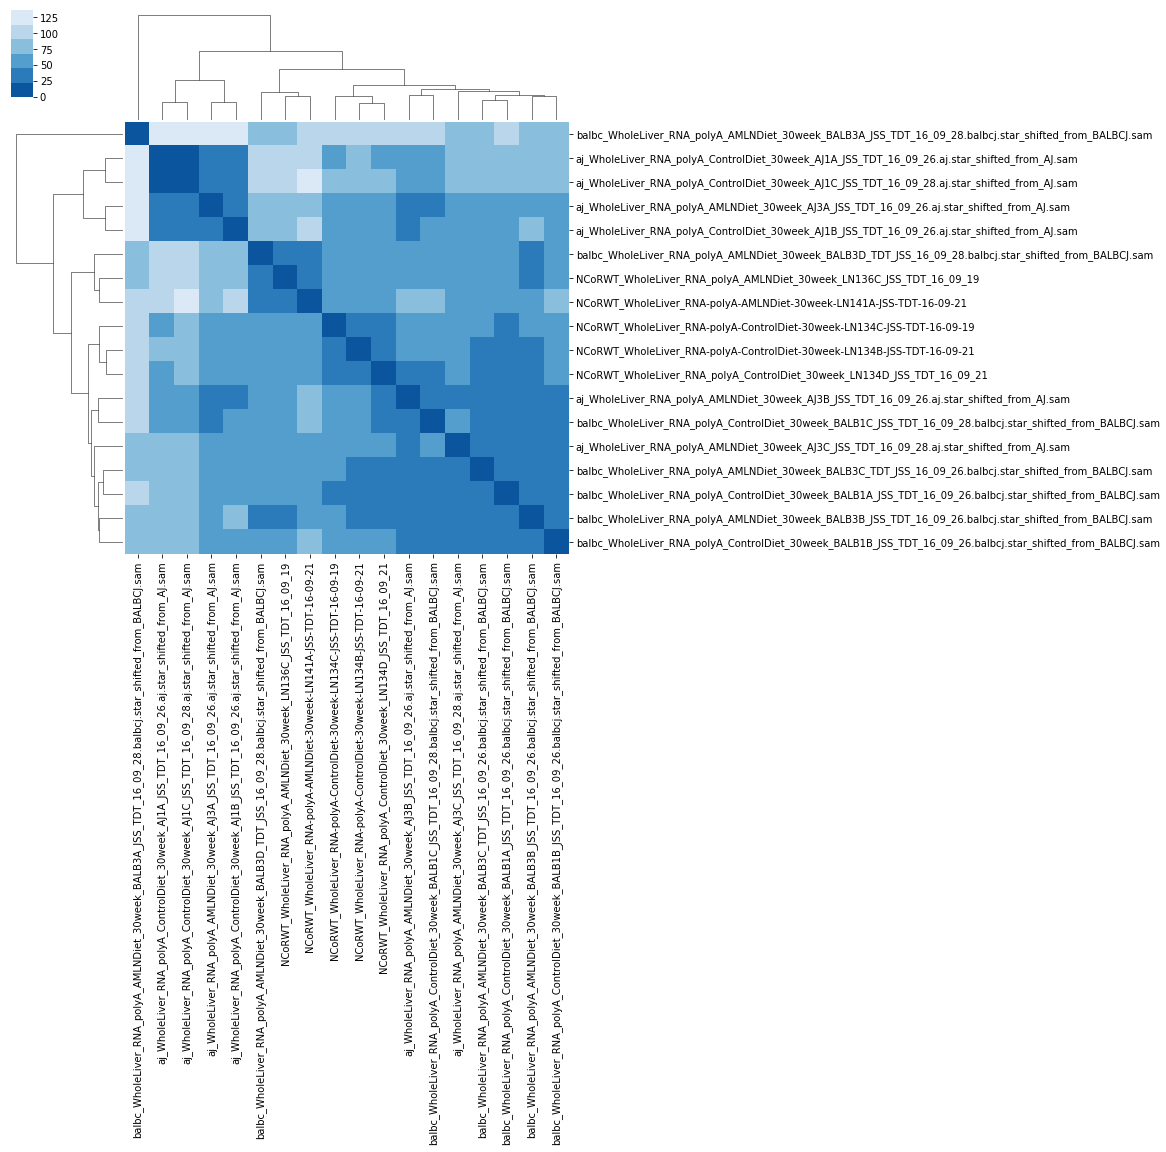

In [56]:
from scipy.spatial import distance
tpm_dist = pd.DataFrame(distance.squareform(distance.pdist(tpm_std.T, 'euclidean')),
                        columns = list(samplesDF.Samples),
                        index = list(samplesDF.Samples))
g = sns.clustermap(tpm_dist, cmap=sns.color_palette("Blues_r"))